In [114]:
import cv2
import os
import joblib
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import torch
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Preparations

In [45]:
# Function to reconstruct full TCI image from tiles in memory
def reconstruct_full_image_from_tiles_in_memory(tile_dir, tile_size=512):
    tile_files = [f for f in os.listdir(tile_dir) if f.endswith('.jpg')]

    # Sort the tile files based on their y and x position in the filename
    tile_files.sort(key=lambda f: (int(f.split('_')[-2]), int(f.split('_')[-1].replace('.jpg', ''))))

    # Extract the max y and x to determine the full image size
    max_y = max(int(f.split('_')[-2]) for f in tile_files)
    max_x = max(int(f.split('_')[-1].replace('.jpg', '')) for f in tile_files)

    # Calculate the size of the full image
    full_height = max_y + tile_size
    full_width = max_x + tile_size

    # Initialize an empty array for the full image
    full_image = np.zeros((full_height, full_width, 3), dtype=np.uint8)

    # Place each tile in its correct position in the full image
    for tile_file in tile_files:
        y = int(tile_file.split('_')[-2])
        x = int(tile_file.split('_')[-1].replace('.jpg', ''))

        # Load the tile
        tile_path = os.path.join(tile_dir, tile_file)
        tile = cv2.imread(tile_path)

        # Place the tile in the full image
        full_image[y:y + tile_size, x:x + tile_size] = tile

    return full_image

In [53]:
# Function to get all TCI image tile folders
def get_tci_tile_folders(root_dir):
    tci_folders = []
    for root, dirs, files in os.walk(root_dir):
        print(root)
        if any('TCI' in file and file.endswith('.jpg') for file in files):
            tci_folders.append(root)

    print(f"Found {len(tci_folders)} folders containing TCI tiles:")
    for folder in tci_folders:
        print(folder)

    return tci_folders

In [59]:
# Get all TCI image tile folders recursively
root_dir = '/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data'

tci_tile_folders = get_tci_tile_folders(root_dir)

/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data
/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190626T083601_B01
/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190626T083601_B02
/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190626T083601_B03
/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190626T083601_B04
/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190626T083601_B05
/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190626T083601_B06
/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190626T083601_B07
/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190626T083601_B08
/content/drive/MyDrive/ Quantum DS Internship/Task 2/Sentinel_dev_data/T36UYA_20190626T083601_B09
/content/drive/MyDrive/ Quantum DS Internship/T

In [102]:
# Dataset class for handling TCI image pairs with balanced positive and negative pairs
class BalancedTCIImagePairDataset(Dataset):
    def __init__(self, tci_tile_folders, transform=None):
        self.tci_tile_folders = tci_tile_folders
        self.transform = transform

        # Reconstruct all full TCI images from tiles
        self.full_tci_images = [reconstruct_full_image_from_tiles_in_memory(folder) for folder in tci_tile_folders]

        # Create balanced pairs
        self.pairs = self._create_balanced_pairs()

    def _create_balanced_pairs(self):
        pairs = []
        num_images = len(self.full_tci_images)

        # Create positive pairs (match with itself)
        for i in range(num_images):
            img1 = self.full_tci_images[i]
            img2 = img1
            pairs.append((img1, img2, 1))

        # Create negative pairs (non-matching images)
        for i in range(num_images):
            img1 = self.full_tci_images[i]
            img2 = random.choice(self.full_tci_images)
            while np.array_equal(img2, img1):
                img2 = random.choice(self.full_tci_images)
            pairs.append((img1, img2, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1, img2, label = self.pairs[idx]

        img1 = Image.fromarray(img1)
        img2 = Image.fromarray(img2)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [103]:
# Transformations for resizing and tensor conversion
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Split the data into training and testing sets
train_tci_folders, test_tci_folders = train_test_split(tci_tile_folders, test_size=0.2, random_state=42)

# Create training and testing datasets
train_dataset = BalancedTCIImagePairDataset(train_tci_folders, transform=transform)
test_dataset = BalancedTCIImagePairDataset(test_tci_folders, transform=transform)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Network Inference

In [104]:
# Define the Siamese Network (same as before)
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.feature_extractor.fc = nn.Identity()  # Remove the last classification layer

        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, image1, image2):
        features1 = self.feature_extractor(image1)
        features2 = self.feature_extractor(image2)

        diff = torch.abs(features1 - features2)
        x = torch.relu(self.fc1(diff))
        output = torch.sigmoid(self.fc2(x))

        return output

# Training function
def train_siamese_network(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (img1, img2, labels) in enumerate(dataloader):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            outputs = model(img1, img2)
            loss = criterion(outputs.squeeze(), labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

# Evaluation function
def evaluate_siamese_network(model, dataloader, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (img1, img2, labels) in enumerate(dataloader):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

## Tests and visualizations

In [105]:
# Function to visualize a pair of images and keypoints with connections between them
def visualize_image_pair_with_keypoints(model, img1, img2, device, sift, num_matches_to_draw=15):
    model.eval()

    # Check if the images are PIL or numpy arrays, and apply the transform
    if isinstance(img1, (Image.Image, np.ndarray)):
        img1_np = np.array(img1) if isinstance(img1, Image.Image) else img1  # Convert to numpy if PIL image
        img1 = transform(img1).unsqueeze(0).to(device)  # Apply transform and move to device
    else:
        img1_np = img1.cpu().numpy().transpose(1, 2, 0)  # Convert tensor to numpy array
        img1 = img1.unsqueeze(0).to(device)  # Already a tensor, just move to device

    if isinstance(img2, (Image.Image, np.ndarray)):
        img2_np = np.array(img2) if isinstance(img2, Image.Image) else img2
        img2 = transform(img2).unsqueeze(0).to(device)
    else:
        img2_np = img2.cpu().numpy().transpose(1, 2, 0)
        img2 = img2.unsqueeze(0).to(device)

    with torch.no_grad():
        similarity_score = model(img1, img2).item()

    img1_np = (img1_np * 255).astype(np.uint8) if img1_np.max() <= 1 else img1_np
    img2_np = (img2_np * 255).astype(np.uint8) if img2_np.max() <= 1 else img2_np

    img1_np = cv2.cvtColor(img1_np, cv2.COLOR_BGR2RGB)
    img2_np = cv2.cvtColor(img2_np, cv2.COLOR_BGR2RGB)

    # Detect keypoints and compute descriptors using SIFT
    kp1, des1 = sift.detectAndCompute(img1_np, None)
    kp2, des2 = sift.detectAndCompute(img2_np, None)

    # Match descriptors between the two images
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Sort matches by distance and keep only the top matches for drawing
    good_matches = sorted(good_matches, key=lambda x: x.distance)[:num_matches_to_draw]

    # Draw keypoints and connections between them
    img_matches = cv2.drawMatches(img1_np, kp1, img2_np, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(10, 5))
    plt.imshow(img_matches)
    plt.axis('off')
    plt.title(f'Similarity Score: {similarity_score:.4f}')
    plt.show()

In [106]:
# Test with some example pairs
def test_model_with_keypoints(model, dataset, device, num_examples=5, num_matches_to_draw=10):
    model.eval()

    for _ in range(num_examples):
        img1, img2, label = dataset[random.randint(0, len(dataset) - 1)]
        sift = cv2.SIFT_create()
        visualize_image_pair_with_keypoints(model, img1, img2, device, sift, num_matches_to_draw=num_matches_to_draw)

## Model training and validation

In [117]:
# Initialize model, criterion, optimizer, and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SiameseNetwork().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train
train_siamese_network(model, train_loader, criterion, optimizer, device, num_epochs=20)

# Evaluate
evaluate_siamese_network(model, test_loader, device)

Epoch [1/20], Loss: 0.6663
Epoch [2/20], Loss: 0.5850
Epoch [3/20], Loss: 0.5607
Epoch [4/20], Loss: 0.5235
Epoch [5/20], Loss: 0.4920
Epoch [6/20], Loss: 0.4821
Epoch [7/20], Loss: 0.4396
Epoch [8/20], Loss: 0.4438
Epoch [9/20], Loss: 0.4224
Epoch [10/20], Loss: 0.4088
Epoch [11/20], Loss: 0.3848
Epoch [12/20], Loss: 0.3220
Epoch [13/20], Loss: 0.3035
Epoch [14/20], Loss: 0.3394
Epoch [15/20], Loss: 0.2693
Epoch [16/20], Loss: 0.2557
Epoch [17/20], Loss: 0.2503
Epoch [18/20], Loss: 0.2257
Epoch [19/20], Loss: 0.1857
Epoch [20/20], Loss: 0.1855
Test Accuracy: 0.7500


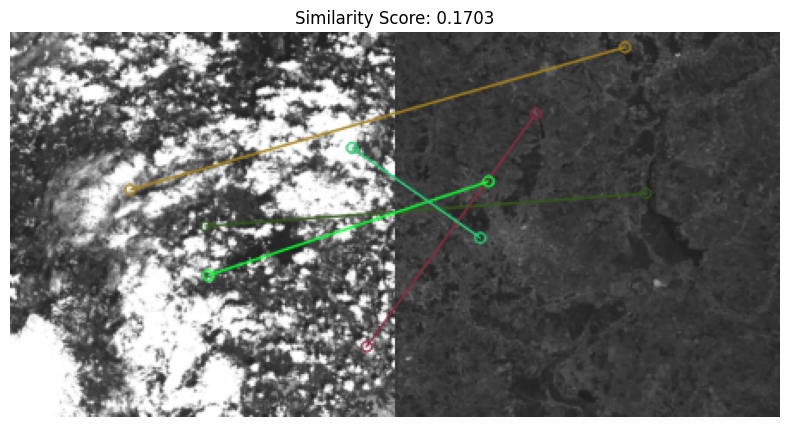

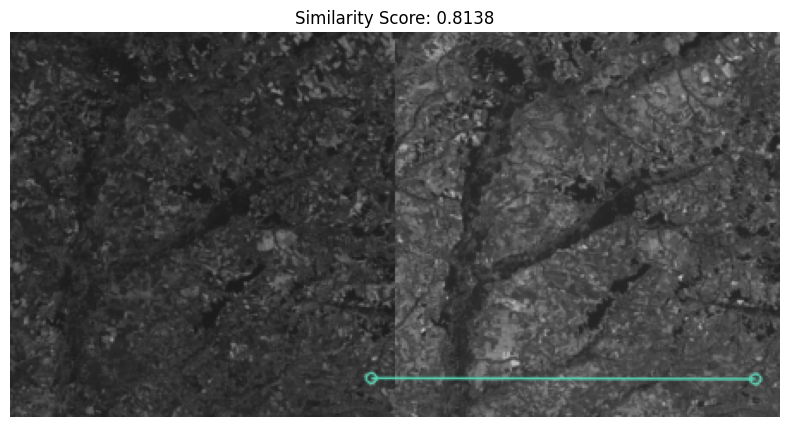

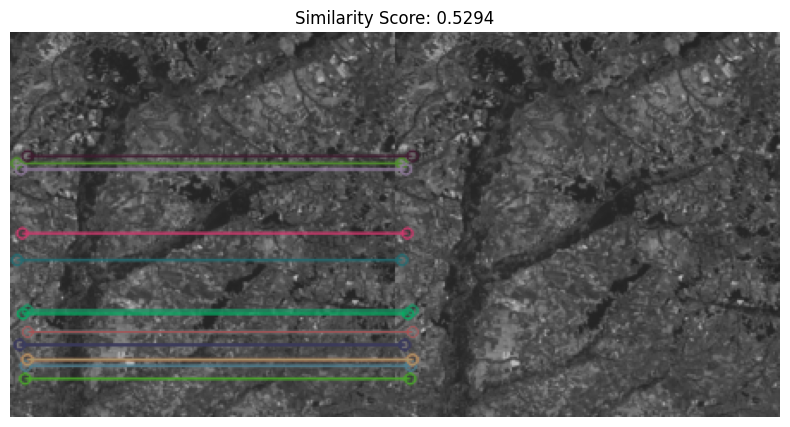

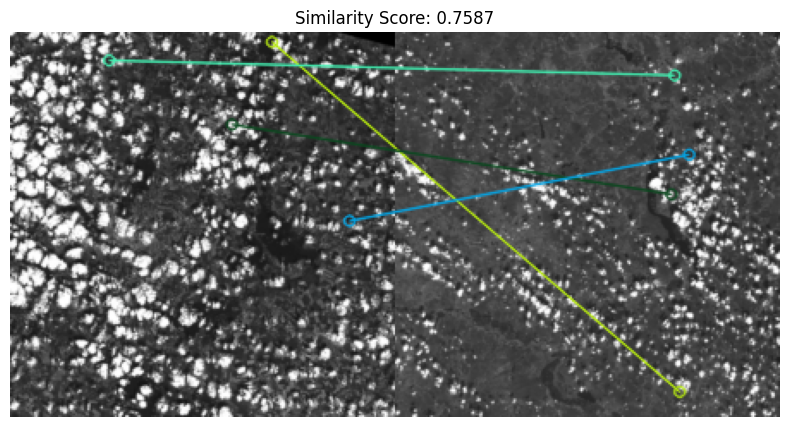

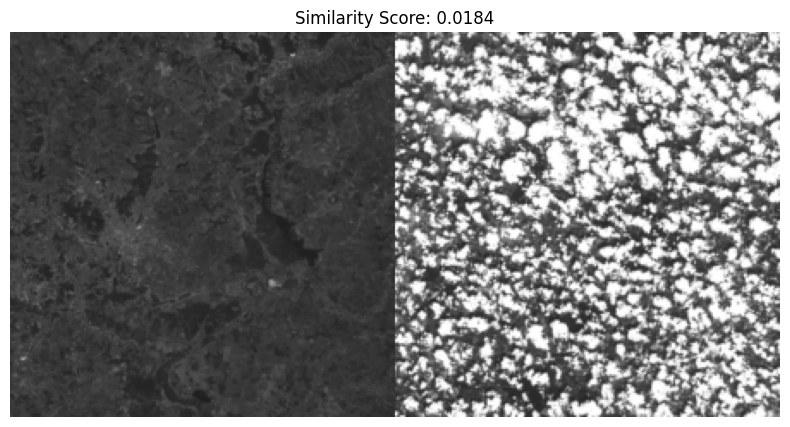

In [118]:
# Run the test with visualization of keypoints
test_model_with_keypoints(model, test_dataset, device, num_examples=5, num_matches_to_draw=15)

In [119]:
def save_siamese_model(model, optimizer, file_path):
    model_state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }

    torch.save(model_state, file_path)
    print(f"Model saved to {file_path}")

def load_siamese_model(file_path, model, optimizer=None, device='cpu'):
    # Load the checkpoint
    checkpoint = torch.load(file_path, map_location=device)

    # Load the model state dictionary
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    print(f"Model loaded from {file_path}")

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return model, optimizer

    return model

In [120]:
save_siamese_model(model, optimizer, '/content/drive/MyDrive/ Quantum DS Internship/Task 2/siamese_model.pth')

Model saved to /content/drive/MyDrive/ Quantum DS Internship/Task 2/siamese_model.pth
